In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
"""
Movie Data
Steps 1
"""

import kagglehub
# Download latest version
path = kagglehub.dataset_download("kaungmyat999/movie-rating-dataset")
print("Path to dataset files:", path)

movies = pd.read_csv('/kaggle/input/movie-rating-dataset/Files/data/movies.csv')
test = pd.read_csv('/kaggle/input/movie-rating-dataset/Files/data/test.csv')
users = pd.read_csv('/kaggle/input/movie-rating-dataset/Files/data/users.csv')
train = pd.read_csv('/kaggle/input/movie-rating-dataset/Files/data/train.csv')

In [ ]:
print(movies.shape)
print(users.shape)


In [ ]:
print("Movies DataFrame:")
print(movies.head())
print("\nTest DataFrame:")
print(test.head())
print("\nUsers DataFrame:")
print(users.head())
print("\nTrain DataFrame:")
print(train.head())

In [ ]:
"""
Movie Data
Steps 1,2
Much of this is copy and pasted from my prior work in Week3
"""

import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from scipy.sparse import coo_matrix


#Create the User-Item Rating Matrix
def create_rating_matrix(train_data, users, movies):
    all_users = users["uID"].unique()
    all_movies = movies["mID"].unique()
    
    user_to_idx = {u: i for i, u in enumerate(all_users)}
    movie_to_idx = {m: i for i, m in enumerate(all_movies)}
    
    ind_user = [user_to_idx[u] for u in train_data["uID"]]
    ind_movie = [movie_to_idx[m] for m in train_data["mID"]]
    ratings = train_data["rating"].values
    
    rating_matrix = coo_matrix(
        (ratings, (ind_user, ind_movie)),
        shape=(len(all_users), len(all_movies))
    ).toarray()
    
    return rating_matrix, user_to_idx, movie_to_idx

rating_matrix, user_to_idx, movie_to_idx = create_rating_matrix(train, users, movies)

#Apply NMF to Decompose the Matrix
n_topics = 2  # Number of latent topics
nmf_model = NMF(n_components=n_topics, init='random', random_state=42, max_iter=1000)
W = nmf_model.fit_transform(rating_matrix)  # User-topic matrix
H = nmf_model.components_  # Topic-item matrix

#Predict Ratings
def predict_rating(W, H, uid, mid, user_to_idx, movie_to_idx):
    if uid not in user_to_idx or mid not in movie_to_idx:
        return 3  # Default neutral rating for unknown users/movies
    user_idx = user_to_idx[uid]
    movie_idx = movie_to_idx[mid]
    return np.dot(W[user_idx, :], H[:, movie_idx])

def predict_ratings(W, H, test_data, user_to_idx, movie_to_idx):
    predictions = []
    for _, row in test_data.iterrows():
        pred = predict_rating(W, H, row["uID"], row["mID"], user_to_idx, movie_to_idx)
        predictions.append(pred)
    return np.array(predictions)

predicted_ratings = predict_ratings(W, H, test, user_to_idx, movie_to_idx)

#Evaluate Predictions with RMSE
def calculate_rmse(predicted, actual):
    predicted = np.nan_to_num(predicted, nan=3)  # Replace NaN with neutral rating
    return np.sqrt(mean_squared_error(actual, predicted))

actual_ratings = test["rating"].values
rmse_value = calculate_rmse(predicted_ratings, actual_ratings)
print(f"RMSE: {rmse_value}")

#Test with Different Numbers of Topics
for n_topics in [2, 5, 10]:
    print(f"\nTesting with {n_topics} topics...")
    nmf_model = NMF(n_components=n_topics, init='random', random_state=42, max_iter=1000)
    W = nmf_model.fit_transform(rating_matrix)
    H = nmf_model.components_
    
    predicted_ratings = predict_ratings(W, H, test, user_to_idx, movie_to_idx)
    rmse_value = calculate_rmse(predicted_ratings, actual_ratings)
    print(f"RMSE: {rmse_value}")

In [ ]:
print(rating_matrix)
total_entries = rating_matrix.size

# Count the number of zeros
num_zeros = (rating_matrix == 0).sum()

# Calculate sparsity
sparsity = num_zeros / total_entries

print(f"Sparsity of the matrix: {sparsity:.4f}")

**Discuss the results and why they did not work well compared to simple baseline or similarity-based methods we’ve done in Module 3. Can you suggest a way(s) to fix it?**

The RMSE scores are above an acceptable range. Below are the baseline, similarity results from week 3 and much better than the 2.9 - 3.1 range above. The sparsity of the data is shown above and I feel like that could be causing the lower worse RMSE score. 

If the goal is to use NMF to find similarity, you could try and reduce the sparsity.
Many techniques in week 3 would come in handy to reduce sparsity for NMF. For example you could replace missing values with average rating for a given user or movie, or replace missing values with the average rating for similar movies or similar users.

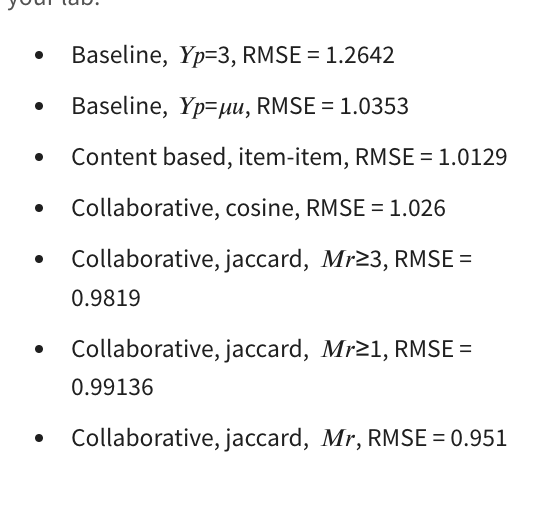

In [ ]:
genre_columns = movies.columns.difference(['mID', 'title', 'year'])

# Sum the values for each genre
genre_sums = movies[genre_columns].sum()

print(genre_sums)